<a href="https://colab.research.google.com/github/MarcosMorales2011/DS-Assignment-Submission-Practice-Repository/blob/master/2020_10_15_234_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

# Wrangle Data

## Import

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [ ]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

## Clean Data

In [ ]:
# Just use 36 month loans
history = history[history.term ==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history = history.dropna()

history['purpose_debt'] = history['Loan Purpose'].str.lower().str.contains('debt').astype(int)
history['purpose_credit'] = history['Loan Purpose'].str.lower().str.contains('credit').astype(int)
history.drop(columns='Loan Purpose', inplace=True)

In [ ]:
history.head()

,Annual Income,Credit Score,Loan Amount,Monthly Debts,Interest Rate,purpose_debt,purpose_credit
issue_d,,,,,,,
2007-07-01,150000.0,779.0,5000.0,0.000000,7.43,0,0
2007-07-01,200000.0,679.0,3000.0,0.000000,10.28,0,0
2007-07-01,95000.0,774.0,5000.0,303.208333,7.43,0,0
2007-07-01,20000.0,684.0,3500.0,25.000000,10.28,0,0
2007-08-01,61800.0,749.0,4000.0,178.190000,7.75,0,0


# Split Data

## Split dataset into training, validation, and testing sets

In [ ]:
# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

## Split target vector from feature matrix

In [ ]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

# Establish Baseline

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 2.8981757786956734


# Build Model

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

model2 = GradientBoostingRegressor(n_estimators=20)
model2.fit(X_train, y_train);

# Check Metrics

In [ ]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

Training MAE: 2.077990831960075
Validation MAE: 2.5460403019695277


In [ ]:
print('Validation R^2:', r2_score(y_val, model.predict(X_val)))

Validation R^2: 0.2729145542290956


# Communicate Results

## Partial Dependence Plots

One Feature

In [ ]:
X_val.columns

Index(['Annual Income', 'Credit Score', 'Loan Amount', 'Monthly Debts',
       'purpose_debt', 'purpose_credit'],
      dtype='object')

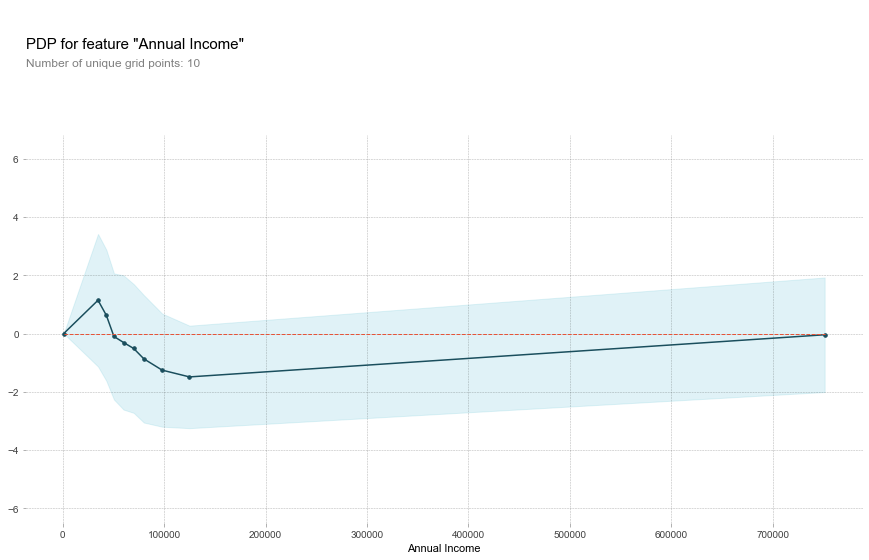

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Annual Income'

isolate = pdp_isolate(
    model=model,
    dataset=X_val, # <-- use validation data
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

Two features

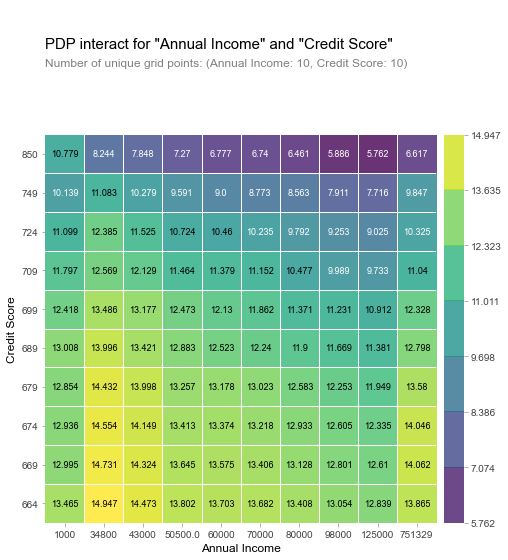

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interact = pdp_interact(
    model=model,
    dataset=X_val, # <-- use validation data
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

## Shapley Plots

- Show you the influence of features in *individual* predictions.

In [ ]:
row = X_val.iloc[[1]]
row

,Annual Income,Credit Score,Loan Amount,Monthly Debts,purpose_debt,purpose_credit
issue_d,,,,,,
2016-12-01,70000.0,684.0,12000.0,621.833333,0,0


In [ ]:
model.predict(row)

array([8.109179], dtype=float32)

In [ ]:
import shap

explainer = shap.TreeExplainer(model2) # <-- Does not like pipelines
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
